In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径

from itertools import chain


In [2]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\趋势变量+噪声变量\\趋势变量加随机噪声-专用数据1.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='建模-分量-全部') 
# excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\数据-时间戳.xlsx'
# df_sheet = pd.read_excel(excel_path, sheet_name='Sheet4') 
# excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\原始数据摘要.xlsx'
# df_sheet = pd.read_excel(excel_path, sheet_name='Sheet1') 
# excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\原始数据摘要.xlsx'
# df_sheet = pd.read_excel(excel_path, sheet_name='建模') 
# excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\原始数据摘要.xlsx'
# df_sheet = pd.read_excel(excel_path, sheet_name='建模-分量') 


print(df_sheet.info())
print(df_sheet.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   时间戳          7398 non-null   float64
 1   铁口1温度        7398 non-null   float64
 2   时间戳.1        7398 non-null   float64
 3   P            7398 non-null   float64
 4   Unnamed: 4   0 non-null      float64
 5   时间戳.2        7398 non-null   float64
 6   SI           7398 non-null   float64
 7   Unnamed: 7   0 non-null      float64
 8   主参数时间戳       7398 non-null   float64
 9   冷风压力         7398 non-null   float64
 10  Unnamed: 10  0 non-null      float64
 11  Unnamed: 11  0 non-null      float64
 12  时间戳.3        7398 non-null   float64
 13  冷风流量         7398 non-null   float64
 14  Unnamed: 14  0 non-null      float64
 15  时间戳.4        7398 non-null   float64
 16  热风温度         7398 non-null   float64
 17  Unnamed: 17  0 non-null      float64
 18  时间戳.5        7398 non-null   float64
 19  设定喷煤量 

In [28]:
# 定义输入输出参数
input_term = ['冷风压力', '冷风流量', '热风温度', '设定喷煤量']
output_term = ['SI']
time_term= '时间戳'


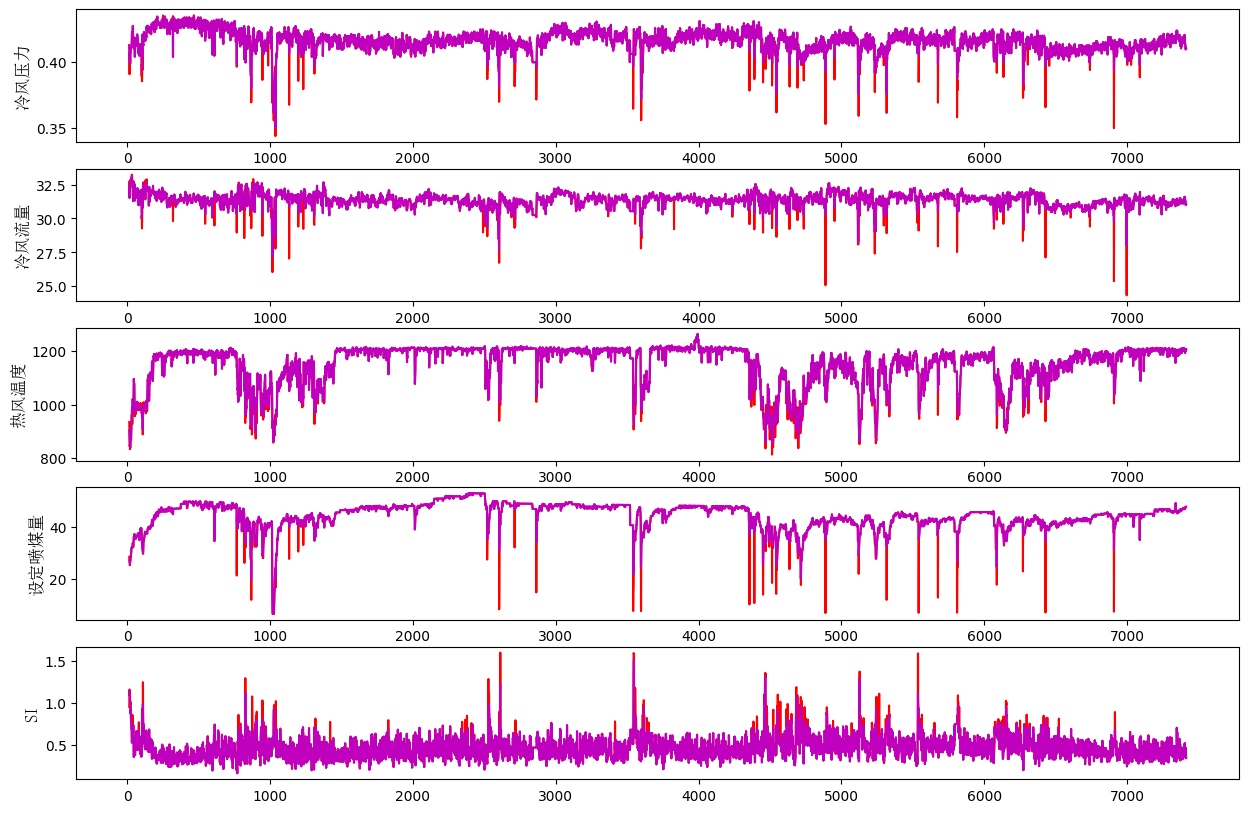

In [97]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 2.25 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value




# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[3]])
replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[output_term[0]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




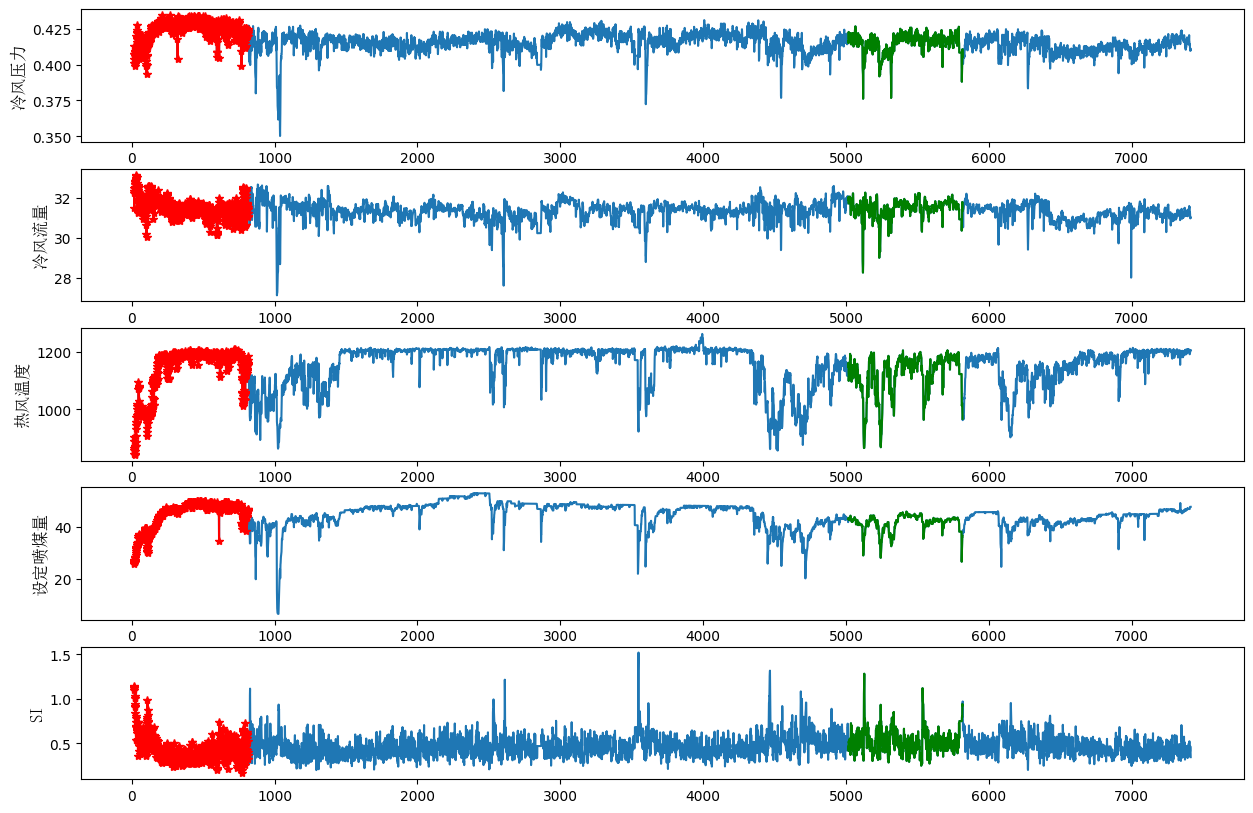

In [98]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='原始数据')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r*-', label='高炉数据')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='预测数据')

    
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签




length1 = 800
start1 = 0
length2 = 800
start2 = 5000


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [99]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_process[input_term[0]].values,
    input_term[1]:   df_sheet_process[input_term[1]].values,
    input_term[2]:   df_sheet_process[input_term[2]].values,
    input_term[3]:   df_sheet_process[input_term[3]].values,
    output_term[0]:  df_sheet_process[output_term[0]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [100]:
# 标定归一化前后数据
# data_point = np.array([1500]).reshape(-1, 1)
# data1 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# data_point = np.array([1510]).reshape(-1, 1)
# data3 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# print('每摄氏度的输出差：',(data3-data1)/(data4-data2))



# data_point = np.array([0.5]).reshape(-1, 1)
# data1 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# data_point = np.array([0.6]).reshape(-1, 1)
# data3 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# print('每0.01浓度的输出差：',(data3-data1))


In [101]:
# 组合训练数据--拆分训练、测试集
train_size = 0.7
val_size = 0.15
test_size = 0.15
def make_data(u1_data,u2_data,u3_data,u4_data,y1_data):
    u1_data = u1_data
    u2_data = u2_data
    u3_data = u3_data
    u4_data = u4_data

    u1_data_1 = np.roll(u1_data, 1)
    u2_data_1 = np.roll(u2_data, 1)
    u3_data_1 = np.roll(u3_data, 1)
    u4_data_1 = np.roll(u4_data, 1)

    y1_data = y1_data

    X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1], u3_data  [1:-1], u4_data  [1:-1],
                            u1_data_1[1:-1], u2_data_1[1:-1], u3_data_1[1:-1], u4_data_1[1:-1]
                            ,y1_data  [1:-1]
                            )
                        )
    y = np.column_stack((y1_data[2:]))

    # 使用 reshape 转换形状(457, 10) (457, 2)--->(457, 1, 10) (457, 1, 2)
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    y_reshaped = y.reshape((y.shape[1], 1, y.shape[0]))
    print('总数据数量：',y.shape)



    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=True)
    
    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/train_size, 
                                                        random_state=42, 
                                                        shuffle=True)




    y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
    y_val = y_val.reshape((y_val.shape[0],y_val.shape[2]))
    y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [102]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
num_samples = y1_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,y1_data)


# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]][index_predict]
u2_data = normalized_data_dict[input_term[1]][index_predict]
u3_data = normalized_data_dict[input_term[2]][index_predict]
u4_data = normalized_data_dict[input_term[3]][index_predict]
y1_data = normalized_data_dict[output_term[0]][index_predict]
num_samples = y1_data.shape[0]
print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,y1_data)


高炉模型数据
总数据数量： (1, 799)
训练数量： (533, 1, 9) (533, 1)
验证数量： (146, 1, 9) (146, 1)
测试数量： (120, 1, 9) (120, 1)
预测模型数据
总数据数量： (1, 799)
训练数量： (533, 1, 9) (533, 1)
验证数量： (146, 1, 9) (146, 1)
测试数量： (120, 1, 9) (120, 1)


In [103]:
# 原有数据归一化后分布
# plt.plot(u1_data)
# plt.plot(u2_data)
# plt.plot(u3_data)
# plt.plot(u4_data)
# plt.plot(y1_data)
# plt.plot(y2_data)


In [104]:
# 定义LSTM模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,features_size,hidden_size,isbidirectional):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=features_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=isbidirectional
        )
        if isbidirectional:
            self.fc = nn.Linear(2 * hidden_size, 1)
        else:
            self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        
        return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse

    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_train) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred.detach().numpy()


In [105]:
# 建立高炉模型实例
features_size = 9
hidden_size = 16
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=True)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []


第 25/25 轮, 训练误差: 0.0121, 验证误差: 0.0041
epoch_sum: 25


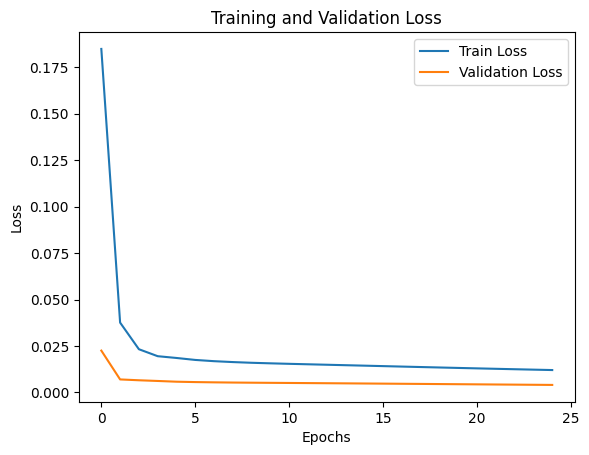

In [106]:
# 高炉模型训练
epoch_once = 25
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=32,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE: SI: 0.0794
MRE : SI: 0.1577
MAPE: SI: 15.7657%
MAE:0.0582,RMSE:0.2413,HR:0.8333,RE:0.0145


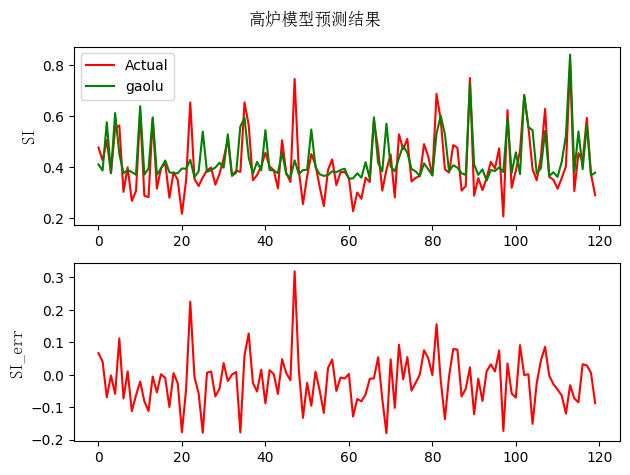

In [107]:
# 高炉模型预测
y_pred_0  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test

# y_test = y_test[:-1]
# y_pred_0 = y_pred_0[1:]

y_test_0 = scalers[output_term[0]].inverse_transform(y_test).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))

# 打印结果
print(f"RMSE: {output_term[0]}: {rmse_0:.4f}")
print(f"MRE : {output_term[0]}: { mre_0:.4f}")
mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
print(f"MAPE: {output_term[0]}: {mape_0:.4f}%")



output0 = y_test_0 - y_pred_0_inverse_transform
MAE = np.mean(np.abs(output0))
RMSE = np.sqrt(MAE)
HR = np.sum(np.abs(output0)<0.1)/len(output0)
RE = np.sum(output0**2)/np.sum(y_gaolu_test**2)
print(f'MAE:{MAE:.4f},RMSE:{RMSE:.4f},HR:{HR:.4f},RE:{RE:.4f}')

plt.subplot(2, 1, 1)
plt.plot(y_test_0,'r', label='Actual')
plt.plot(y_pred_0_inverse_transform,'g', label='gaolu')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签
plt.suptitle('高炉模型预测结果', fontproperties=font)  # 添加整个图形的标题
plt.tight_layout()
plt.show()



In [108]:
# 创建预测模型实例
features_size = 9
hidden_size_predict = 16
torch.manual_seed(0)
model = MyRNNModel(features_size = features_size, 
                    hidden_size = hidden_size_predict,
                    isbidirectional=True)
epoch_sum_predict = 0
predict_train_loss_list = []
predict_val_loss_list = []


第 25/25 轮, 训练误差: 0.0174, 验证误差: 0.0053
epoch_sum: 0


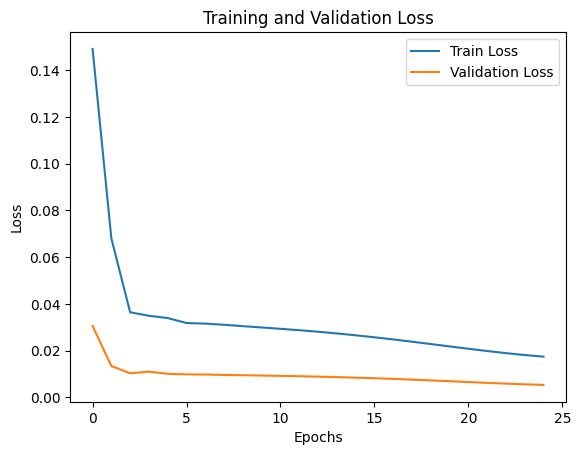

In [109]:
# 预测模型训练
epoch_once = 25
epoch_sum = epoch_sum_predict + epoch_once
predict_train_loss_list, predict_val_loss_list = model.my_fit(X_predict_train, y_predict_train,
                                    X_predict_val, y_predict_val, 
                                    predict_train_loss_list, predict_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_predict)


# 绘制训练和验证损失曲线
plt.plot(predict_train_loss_list, label='Train Loss')
plt.plot(predict_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE: SI: 0.0944
MRE : SI: 0.1282
MAPE: SI: 12.8191%
MAE:0.0685,RMSE:0.2617,HR:0.7583,RE:0.0204


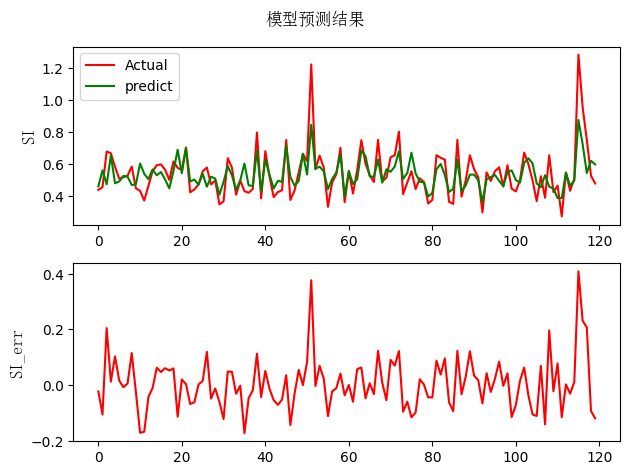

In [110]:
# 预测模型预测
y_pred_0 = model.my_predict(X_predict_test)

# 计算 RMSE、MRE
y_test = y_predict_test

# y_test = y_test[:-1]
# y_pred_0 = y_pred_0[1:]
# y_pred_1 = y_pred_1[1:]

#

y_test_0 = scalers[output_term[0]].inverse_transform(y_test).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))

# 打印结果
print(f"RMSE: {output_term[0]}: {rmse_0:.4f}")
print(f"MRE : {output_term[0]}: { mre_0:.4f}")
mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
print(f"MAPE: {output_term[0]}: {mape_0:.4f}%")



output0 = y_test_0 - y_pred_0_inverse_transform
MAE = np.mean(np.abs(output0))
RMSE = np.sqrt(MAE)
HR = np.sum(np.abs(output0)<0.1)/len(output0)
RE = np.sum(output0**2)/np.sum(y_gaolu_test**2)
print(f'MAE:{MAE:.4f},RMSE:{RMSE:.4f},HR:{HR:.4f},RE:{RE:.4f}')

plt.subplot(2, 1, 1)
plt.plot(y_test_0,'r', label='Actual')
plt.plot(y_pred_0_inverse_transform,'g', label='predict')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签
plt.suptitle('模型预测结果', fontproperties=font)  # 添加整个图形的标题
plt.tight_layout()
plt.show()



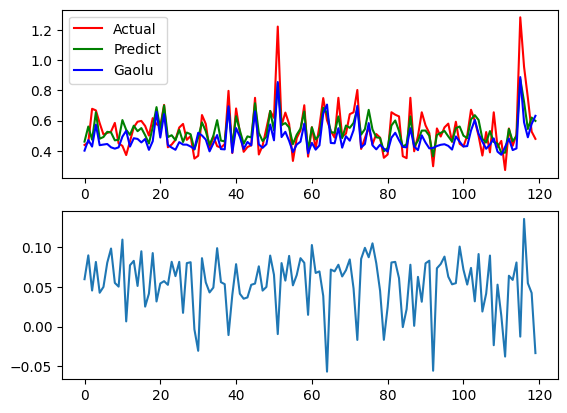

In [111]:
y_test = y_predict_test
y_test_0 = scalers[output_term[0]].inverse_transform(y_test).flatten()
y_pred_0 = model.my_predict(X_predict_test)
y_pred_0_predict = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()

y_pred_0  = model_gaolu.my_predict(X_predict_test)
y_pred_0_gaolu = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()

plt.subplot(2, 1, 1)

plt.plot(y_test_0, 'r-', label='Actual')
plt.plot(y_pred_0_predict, 'g-', label='Predict')
plt.plot(y_pred_0_gaolu, 'b', label='Gaolu')

plt.legend()


plt.subplot(2, 1, 2)
plt.plot(y_pred_0_predict-y_pred_0_gaolu)




In [112]:
# # 保存模型参数到文件
# torch.save(model.state_dict(), 'model_predict_params.pth')
# torch.save(model_gaolu.state_dict(), 'model_gaolu_params.pth')



In [113]:
# 自定义预测
model_predict = model
hidden_size = hidden_size_predict
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lstm_forward(input, initial_states, w_ih, w_hh, b_ih, b_hh):
    h_0, c_0 = initial_states  # 初始状态  [b_size, hidden_size]
    b_size, seq_len, input_size = input.shape
    h_size = h_0.shape[-1]

    h_prev, c_prev = h_0, c_0

    # 使用 np.newaxis 在第一个维度上插入一个新的维度  # 使用 np.tile 在第一个维度上复制 b_size 次
    w_ih_expanded = w_ih[np.newaxis, :, :]    
    w_ih_batch = np.tile(w_ih_expanded, (b_size, 1, 1))
    w_hh_expanded = w_hh[np.newaxis, :, :]    
    w_hh_batch = np.tile(w_hh_expanded, (b_size, 1, 1))
    # print(w_ih_batch.shape)

    output_size = h_size
    output = np.zeros((b_size, seq_len, output_size))  # 初始化一个输出序列
    for t in range(seq_len):
        x = input[:, t, :]  # 当前时刻的输入向量 [b,in_size]->[b,in_size,1]
        w_times_x = np.matmul(w_ih_batch, x[:, :, np.newaxis]).squeeze(-1)   # bmm:含有批量大小的矩阵相乘
        # [b, 4*hidden_size, 1]->[b, 4*hidden_size]
        # 这一步就是计算了 Wii*xt|Wif*xt|Wig*xt|Wio*xt
        w_times_h_prev = np.matmul(w_hh_batch, h_prev[:, :, np.newaxis]).squeeze(-1)
        # [b, 4*hidden_size, hidden_size]*[b, hidden_size, 1]->[b,4*hidden_size, 1]->[b, 4*hidden_size]
        # 这一步就是计算了 Whi*ht-1|Whf*ht-1|Whg*ht-1|Who*ht-1

        # 分别计算输入门(i)、遗忘门(f)、cell门(g)、输出门(o)  维度均为 [b, h_size]
        i_t = sigmoid(w_times_x[:, :h_size] + w_times_h_prev[:, :h_size] + b_ih[:h_size] + b_hh[:h_size])  # 取前四分之一
        f_t = sigmoid(w_times_x[:, h_size:2*h_size] + w_times_h_prev[:, h_size:2*h_size]
                            + b_ih[h_size:2*h_size] + b_hh[h_size:2*h_size])
        g_t = np.tanh(w_times_x[:, 2*h_size:3*h_size] + w_times_h_prev[:, 2*h_size:3*h_size]
                            + b_ih[2*h_size:3*h_size] + b_hh[2*h_size:3*h_size])
        o_t = sigmoid(w_times_x[:, 3*h_size:] + w_times_h_prev[:, 3*h_size:]
                            + b_ih[3*h_size:] + b_hh[3*h_size:])
        c_prev = f_t * c_prev + i_t * g_t
        h_prev = o_t * np.tanh(c_prev)

        output[:, t, :] = h_prev

    return output, (np.expand_dims(h_prev, axis=0), np.expand_dims(c_prev, axis=0))  # 官方是三维，在第0维扩一维



def predict_my(data_input):

    input = data_input  # 随机初始化一个输入序列
    c_0 = np.zeros((data_input.shape[0], hidden_size))  # 初始值，不会参与训练
    h_0 = np.zeros((data_input.shape[0], hidden_size))

    output_forward, (h_n_me, c_n_me) = lstm_forward(input, (h_0, c_0), 
                                                model_predict.lstm.weight_ih_l0.detach().numpy(),
                                                model_predict.lstm.weight_hh_l0.detach().numpy(), 
                                                model_predict.lstm.bias_ih_l0.detach().numpy(), 
                                                model_predict.lstm.bias_hh_l0.detach().numpy())

    last_lstm_output_forward = output_forward[:, -1, :]

    output_backward, (h_n_me, c_n_me) = lstm_forward(input, (h_0, c_0), 
                                                model_predict.lstm.weight_ih_l0_reverse.detach().numpy(),
                                                model_predict.lstm.weight_hh_l0_reverse.detach().numpy(), 
                                                model_predict.lstm.bias_ih_l0_reverse.detach().numpy(), 
                                                model_predict.lstm.bias_hh_l0_reverse.detach().numpy())

    last_lstm_output_backward = output_backward[:, -1, :]
    # print(last_lstm_output_forward.shape)
    # print(last_lstm_output_backward.shape)
    # 最终输出
    combined_hidden = np.concatenate((last_lstm_output_forward, last_lstm_output_backward), axis=1)
    # print(combined_hidden.shape)


    output = (np.dot(combined_hidden, np.transpose(model_predict.fc.weight.detach().numpy()))
                + model_predict.fc.bias.detach().numpy()
)
    y_pred_0= output[:,0]

    # y_pred_0 = scalers[output_term[0]].inverse_transform(np.array(y_pred_0).reshape(-1, 1)).flatten()
    # y_pred_1 = scalers[output_term[1]].inverse_transform(np.array(y_pred_1).reshape(-1, 1)).flatten()




    return y_pred_0


y_pred_0= predict_my(X_predict_test)

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)
# plot_hit_rate_curve(y_test, y_pred_0.detach().numpy(), y_pred_1.detach().numpy())





In [114]:
# 生成期望数据
Times = 100

def generate_y_aim_data(Times):
    if output_term == ['铁口1温度插补'] or output_term == ['铁口1温度']:
        set_y1 = np.full(Times,1500)
        set_y1[10:] = 1510
        set_y1[30:] = 1520
        set_y1[50:] = 1530
        set_y1[70:] = 1540
        set_y1[90:] = 1550
        # set_y1[130:151] = 1500
        # set_y1[170:201] = 1500
        # set_y1[80] = 1515  # 添加脉冲干扰
    elif output_term == ['SI插补'] or output_term == ['SI']:
        set_y1 = np.full(Times,0.40)
        set_y1[20:] = 0.42
        set_y1[40:] = 0.44
        set_y1[60:] = 0.46
        set_y1[80:] = 0.48
        # set_y1[130:151] = 1500
        # set_y1[170:201] = 1500
        # set_y1[80] = 0.45  # 添加脉冲干扰
    elif output_term == ['P插补']or output_term == ['P']:
        set_y1 = np.full(Times,0.14)
        set_y1[20:] = 0.145
        set_y1[40:] = 0.150
        set_y1[60:] = 0.155
        set_y1[80:] = 0.160
        # set_y1[130:151] = 1500
        # set_y1[170:201] = 1500
        # set_y1[80] = 0.45  # 添加脉冲干扰
    elif output_term == ['冷风压力']:
        set_y1 = np.full(Times,0.43)
        set_y1[15:] = 0.42
        set_y1[30:] = 0.43
        # set_y1[130:151] = 1500
        # set_y1[170:201] = 1500
        # set_y1[80] = 0.45  # 添加脉冲干扰

    set_y2 = set_y1
    
    set_y1_trans = scalers[output_term[0]].transform(set_y1.reshape(-1,1)).flatten()
    set_y2_trans = set_y1_trans

    return set_y1, set_y2, set_y1_trans, set_y2_trans

# # 调用示例
# set_y1, set_y2, set_y1_trans, set_y2_trans= generate_y_aim_data(Times)
# plt.plot(set_y1_trans)
# plt.plot(set_y2_trans)
# plt.title('y_sp')
# plt.show()



In [115]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * aim_value

    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()
    return y_r
# 测试
y_r = get_yr(1,-0.5,0.667,5+1)


In [116]:
#生成控制时域的数据格式
def generate_k_data(u1_data, u2_data, u3_data, u4_data, y1_data, num_samples, P):
    nearest_index = np.abs(y1_data - (-0.58)).argmin()
    # 生成随机索引值
    #从原有数据的randint时刻开始往下进行控制
    randint = np.random.randint(1, num_samples - 2 - P - 1)
    randint = nearest_index  # 如果你希望使用固定的值而不是随机生成
    # randint = 250  # 如果你希望使用固定的值而不是随机生成
    print(randint)
    # 提取数据并构成 k_data
    # 第一次得到下面五个变量，固定好格式构成k_data
    u1   = u1_data[randint  :randint+2  ]
    u2   = u2_data[randint  :randint+2  ]
    u3   = u3_data[randint  :randint+2  ]
    u4   = u4_data[randint  :randint+2  ]
    u1_1 = u1_data[randint-1:randint+2-1]
    u2_1 = u2_data[randint-1:randint+2-1]    
    u3_1 = u3_data[randint-1:randint+2-1]
    u4_1 = u4_data[randint-1:randint+2-1]

    y1   = y1_data[randint  :randint+2  ]
    y2   = y1_data[randint  :randint+2  ]
    k_data = np.concatenate((u1, u2, u3, u4, u1_1, u2_1, u3_1, u4_1, y1, y2), axis=0)
    # print(k_data.shape)

    k_data = np.zeros_like(k_data)
    return k_data

# print(k_data)


In [117]:
# 定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim,isprint,E1_k_0,k):
    # if k>1:
    #     h = 0
    # else:
    h = 1.0

    lamda1 = 1.0
    lamda2 = lamda1
    lamda3 = lamda1
    lamda4 = lamda1
    y1_percent = 10.0
    y2_percent = 1.0
    # lamda1 = 0.001
    # y1_percent = 8.528
    # y2_percent = 1.0

    # 从固定格式k_data里面读取信息
    u1   = k_data[0:2]
    u2   = k_data[2:4]
    u3   = k_data[4:6]
    u4   = k_data[6:8]
    u1_1 = k_data[8:10]
    u2_1 = k_data[10:12]
    u3_1 = k_data[12:14]
    u4_1 = k_data[14:16]

    y1   = k_data[16:18]
    y2   = k_data[18:20]
    # 获取猜测值[h U1 U2]
    # h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    U1, U2, U3, U4  =params[0:M], params[M:2*M],params[2*M:3*M], params[3*M:4*M]

    # 整理数据见   MPC推到.escel
    u1   = np.concatenate((u1[:1],U1))
    u2   = np.concatenate((u2[:1],U2))
    u3   = np.concatenate((u3[:1],U3))
    u4   = np.concatenate((u4[:1],U4))

    u1_1 = np.concatenate((u1_1[:2],U1[:-1]))
    u2_1 = np.concatenate((u2_1[:2],U2[:-1]))
    u3_1 = np.concatenate((u3_1[:2],U3[:-1]))
    u4_1 = np.concatenate((u4_1[:2],U4[:-1]))

    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))
    y1_k = y1[1]
    y2_k = y2[1]
    # print(u1)
    # print(u2)
    # print(u1_1)
    # print(u2_1)
    # print(y1)
    # print(y2)
    # print(y1_k)    
    # print(y2_k)

    # 总共预测 P+1 次
    # 对k时刻进行预测-----1次
    
    for j in range(1):
        x = np.column_stack((u1[j],u2[j],u3[j],u4[j],u1_1[j],u2_1[j],u3_1[j],u4_1[j],y1[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_m_k = predict_my(x)
        
        # y1[j+1] = y1_m_k.item()###############################是否替换不知道有没有影响？
        # y2[j+1] = y2_m_k.item()###############################
        # 在k时刻，我要先通过k-1时刻来预测出当前k时刻下的预测值。
        # 实际上，这个时候我有k时刻的真实值。
        # 但是这么做是为了能够获取我的预测值和真实值之间的误差，
        # 然后基于这个误差，通过对控制器输入的调整来预测k+1时刻，
        # 然后依次往下。因此，在k时刻，我系统的值是固定的，
        # 也就是我的真实值，所以我要把它存储到我的整体的一个序列里面。
        # 在取出当前k时刻真实值的过程中，我不能将之前预测的时候的那个
        # 预测值覆盖掉真实值。后面新预测的数值要加上前面的那一个误差
        E1_k = y1_k - y1_m_k
        # E2_k = y2_k - y2_m_k




    # 对每个U对应的控制时刻进行预测-----M次
    for j in range(1,M+1):  
        x = np.column_stack((u1[j],u2[j],u3[j],u4[j],u1_1[j],u2_1[j],u3_1[j],u4_1[j],y1[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j= predict_my(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        # y2[j+1] = y2_k_j.item()

    # 对控制时域外的部分进行预测-----P-M次
    # 注意：这部分的信号是保持控制不变下进行
    for j in range(M+1,P+1):
        x = np.column_stack((u1[-1],u2[-1],u3[-1],u4[-1],u1[-1],u2[-1],u3[-1],u4[-1],y1[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j= predict_my(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        # y2[j+1] = y2_k_j.item()

    k_data2 = np.concatenate((u1[1:3],u2[1:3],u3[1:3],u4[1:3],u1_1[1:3],u2_1[1:3],u3_1[1:3],u4_1[1:3],y1[1:3],y2[1:3]),axis=0)



    #和获取参考轨迹
    # 一定要对照好做差的序列
    y1_r_aim  = get_yr(y1_aim,y1_k,0.005,P+1)
    y1_r = y1_r_aim[1:] 


    y2_r_aim  = get_yr(y2_aim,y2_k,0.005,P+1)
    y2_r = y2_r_aim[1:] 

    y1_M_k = y1[2:]
    y2_M_k = y2[2:]
    
    if isprint==1:

        print('y1_k',y1_k)  
        print('y1_m_k',y1_m_k)    
        print('y2_k',y2_k)  

        print('temp:')
        print('y1_aim',y1_aim)
        print('y1_r_aim',y1_r_aim)
        print('y1_r',y1_r)
        print('y1_M_k+h*E1_k',y1_M_k+h*E1_k)

        print('y1',y1)
        print('h*E1_k',h*E1_k)
    
        print('u:')
        print(u1)
        print(u2)
        print(u3)
        print(u4)



    # 计算mse
    # lamda1太大的话会导致y1_r和y1_M_k的误差加大*****************导致超调的原因\与目标值之间存在间隙
    
    # if np.abs(y1_aim-y1_k)<0.0001 and np.abs(y2_aim-y2_k)<0.0001:
    #     lamda1 = 1

    y1_err = y1_percent*np.sum(np.abs(y1_r-(y1_M_k+h*E1_k))**2) 
    # y2_err = y2_percent*np.sum((y2_r-(y2_M_k+h*E2_k))**2) 
    u1_power = np.sum(((np.diff(lamda1*u1)**2)))
    u2_power = np.sum(((np.diff(lamda2*u2)**2)))
    u3_power = np.sum(((np.diff(lamda3*u3)**2)))
    u4_power = np.sum(((np.diff(lamda4*u3)**2)))

    mse = (0
            # +loss_function(y1_r, y1_M_k+h*E1_k, weights)
            # +loss_function(y2_r, y2_M_k+h*E2_k, weights)
            # +(np.abs(y1_aim-y1_k)**2+np.abs(y2_aim-y2_k)**2)*P*2000
            # +np.sum((y1_r-y1_M_k-h*E1_k)**2 + (y2_r-y2_M_k-h*E2_k)**2)
            +y1_err
            # +y2_err


            +u1_power
            +u2_power
            +u3_power
            +u4_power

            )
    
    # print('mse {:.7f}'.format(mse))
    if isprint==1:
        print('mse {:.7f}'.format(mse))
        print('0000 {:.7f}'.format(y1_err))
        # print('2222 {:.7f}'.format(y2_err))
        print('1111 {:.7f}'.format(u1_power))
        print('2222 {:.7f}'.format(u2_power))
        print('3333 {:.7f}'.format(u3_power))
        print('4444 {:.7f}'.format(u4_power))


    return mse , k_data2,E1_k


In [118]:
# 对未来Times周期预测控制
isprint = 0
max_control = 1
E1_k_0 = 0
# 期望设定值
set_y1, set_y2, set_y1_trans, set_y2_trans = generate_y_aim_data(Times)

# MPC参数
P = 3  # 预测时域长度
M = 2  # 控制时域长度
#生成控制时域的数据格式
k_data = generate_k_data(u1_data, u2_data, u3_data, u4_data, 
                        y1_data, num_samples, P)

# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_u3 = []
all_pred_u4 = []
# MPC控制循环10010050
for k in range(Times):
    print(f"这是对第{k}时刻的最优U1、U2输入求解")
    # print('y1_aim  y2_aim',set_y1[k],set_y2[k])
    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2,E1_k_0 = my_MPC(k_data=k_data[0], params=params, 
                                M=M, P=P, 
                                y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                                isprint = 0,E1_k_0=k_data[1],k=k_data[2]) 
        return mse
    
    # 初始猜测值[h U1 U2]
    params = np.concatenate([np.ones(M), np.ones(M),np.ones(M), np.ones(M)])
    # 定义参数的上下限  
    bounds = [(-max_control, max_control) for _ in range(4 * M)]

    # 进行优化
    result = minimize(objective_function, params, method='L-BFGS-B', 
                    bounds=bounds, args=(k_data, E1_k_0,k))#args传进来的是一个元组
    
    
    # # 查看退出条件
    # if result.success:
    #     print("优化成功收敛!")
    # else:
    #     print("优化未成功收敛。")
    #     # 打印其他结果信息
    # print("最优参数:", result.x)
    # print("最优函数值:", result.fun)
    # print("迭代次数:", result.nit)
    # print("Gradient:", result.jac)
    optimized_U1, optimized_U2, optimized_U3, optimized_U4 = result.x[0:M], result.x[M:2*M], result.x[2*M:3*M], result.x[3*M:4*M]


    # 获取当前时刻下，在最优的U1、U2下的响应    
    u1_k = optimized_U1[0]
    u2_k = optimized_U2[0]
    u3_k = optimized_U3[0]
    u4_k = optimized_U4[0]
    u1_k_1 = k_data[9]
    u2_k_1 = k_data[11]
    u3_k_1 = k_data[13]
    u4_k_1 = k_data[15]
    y1_k = k_data[17] 
    y2_k = k_data[19] 

    
    x = np.column_stack((u1_k,u2_k,u3_k,u4_k,u1_k_1,u2_k_1,u3_k_1,u4_k_1,y1_k))
    x = x.reshape((x.shape[0], 1, x.shape[1]))
    y1_pred0= model.my_predict(x)
    y1_pred = model_gaolu.my_predict(x)
    # if isprint:
    print('asdfghjk',set_y1_trans[k],y1_pred0, y1_pred, set_y1_trans[k]-y1_pred)
    print(y1_pred0-y1_pred)
    



    # print("666666666666")
    
    # 获取当前时刻下，在最优的U1、U2下的响应
    params = np.concatenate((optimized_U1,optimized_U2,optimized_U3,optimized_U4),axis=0)
    mse, k_data2,E1_k_0 =my_MPC(k_data=k_data,params=params,
                            M=M,P=P, 
                            y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                            isprint = isprint,E1_k_0=E1_k_0,k=k) 
    # print(E1_k_0)
    
    # print('y1_pred',scalers[output_term[0]].inverse_transform(np.array(y1_pred).reshape(-1, 1)).flatten())
    # print('y2_pred',scalers[output_term[1]].inverse_transform(np.array(y2_pred).reshape(-1, 1)).flatten())
    
    all_pred_y1.append(y1_pred)
    all_pred_y2.append(0)
    all_pred_u1.append(u1_k)
    all_pred_u2.append(u2_k)
    all_pred_u3.append(u3_k)
    all_pred_u4.append(u4_k)
    k_data2[17] = y1_pred
    k_data2[19] = 0
    k_data = k_data2
    # 进入下一时刻，更新预测时域、控制时域，即k_data


640
这是对第0时刻的最优U1、U2输入求解
asdfghjk -0.6543815043617833 [[-0.42373085]] [[-0.40589574]] [[-0.24848577]]
[[-0.01783511]]
这是对第1时刻的最优U1、U2输入求解


C:\Users\haokw\AppData\Local\Temp\ipykernel_7084\1917329194.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_data2[17] = y1_pred


asdfghjk -0.6543815043617833 [[-0.6456611]] [[-0.54734635]] [[-0.10703516]]
[[-0.09831476]]
这是对第2时刻的最优U1、U2输入求解
asdfghjk -0.6543815043617833 [[-0.7067584]] [[-0.5792458]] [[-0.07513571]]
[[-0.12751257]]
这是对第3时刻的最优U1、U2输入求解
asdfghjk -0.6543815043617833 [[-0.7241967]] [[-0.58850884]] [[-0.06587267]]
[[-0.13568783]]
这是对第4时刻的最优U1、U2输入求解
asdfghjk -0.6543815043617833 [[-0.7326982]] [[-0.5930008]] [[-0.06138068]]
[[-0.13969737]]
这是对第5时刻的最优U1、U2输入求解
asdfghjk -0.6543815043617833 [[-0.73907864]] [[-0.5962442]] [[-0.0581373]]
[[-0.14283442]]
这是对第6时刻的最优U1、U2输入求解
asdfghjk -0.6543815043617833 [[-0.7446984]] [[-0.59897065]] [[-0.05541086]]
[[-0.14572775]]
这是对第7时刻的最优U1、U2输入求解
asdfghjk -0.6543815043617833 [[-0.7498646]] [[-0.6013638]] [[-0.05301774]]
[[-0.1485008]]
这是对第8时刻的最优U1、U2输入求解
asdfghjk -0.6543815043617833 [[-0.75467443]] [[-0.60349274]] [[-0.05088878]]
[[-0.1511817]]
这是对第9时刻的最优U1、U2输入求解
asdfghjk -0.6543815043617833 [[-0.75917757]] [[-0.6053984]] [[-0.0489831]]
[[-0.15377915]]
这是对第10时刻的最优U1、U2输入

上线分别是：[0.4344341  0.35020406]、[33.16828629 27.14167883]、[1263.5221402   841.53712915]、[53.10015501  6.3258078 ]


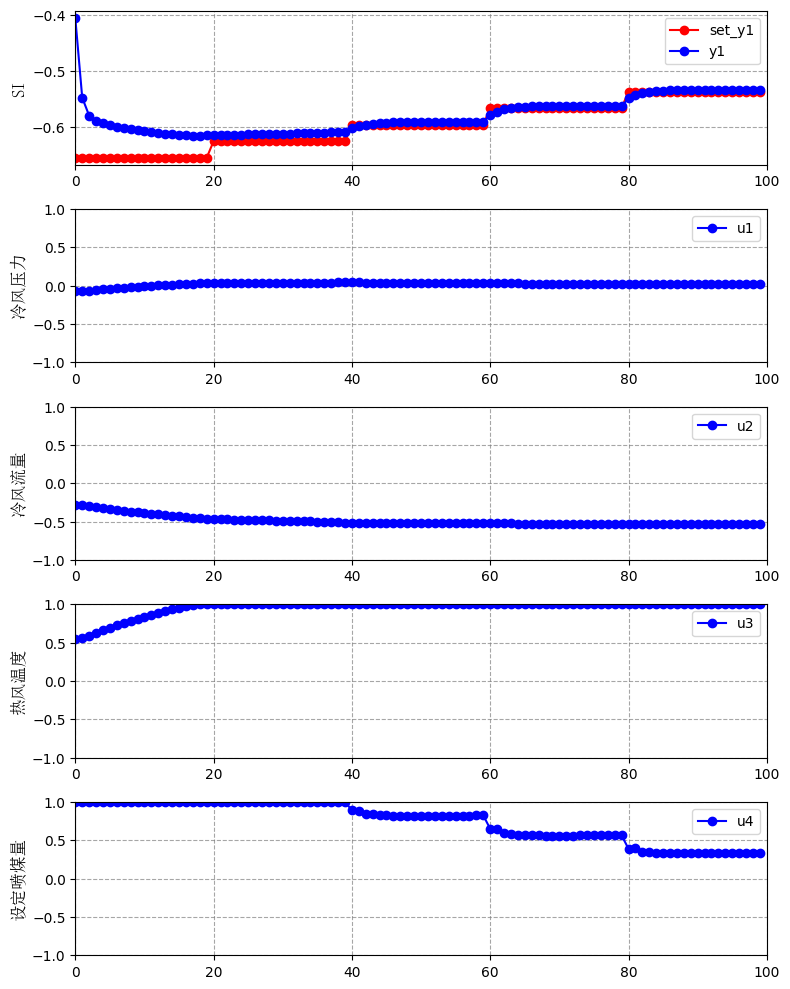

In [119]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(8, 10))
y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1).reshape(-1, 1)).flatten()
all_pred_u1_inverse_transform = scalers[input_term[0]].inverse_transform(np.array(all_pred_u1).reshape(-1, 1)).flatten()
all_pred_u2_inverse_transform = scalers[input_term[1]].inverse_transform(np.array(all_pred_u2).reshape(-1, 1)).flatten()
all_pred_u3_inverse_transform = scalers[input_term[2]].inverse_transform(np.array(all_pred_u3).reshape(-1, 1)).flatten()
all_pred_u4_inverse_transform = scalers[input_term[3]].inverse_transform(np.array(all_pred_u4).reshape(-1, 1)).flatten()
a1 = scalers[input_term[0]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a2 = scalers[input_term[1]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a3 = scalers[input_term[2]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a4 = scalers[input_term[3]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
print(f'上线分别是：{a1}、{a2}、{a3}、{a4}')
# print(all_pred_u1)
# print(all_pred_u2)
# print(all_pred_u3)
# print(all_pred_u4)
# 第一个维度的曲线
plt.subplot(5, 1, 1)
plt.plot(set_y1_trans, 'ro-', label='set_y1')
plt.plot(np.array(all_pred_y1).reshape(-1, 1), 'bo-', label='y1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')


# 第一个维度的u1曲线
plt.subplot(5, 1, 2)
plt.plot(all_pred_u1, 'bo-', label='u1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylim((-max_control,max_control))
plt.ylabel(input_term[0], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的u2曲线
plt.subplot(5, 1, 3)
plt.plot(all_pred_u2, 'bo-', label='u2')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylim((-max_control,max_control))
plt.ylabel(input_term[1], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第三个维度的u3曲线
plt.subplot(5, 1, 4)
plt.plot(all_pred_u3, 'bo-', label='u3')  # 修改标签为 'u3'
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylim((-max_control,max_control))
plt.ylabel(input_term[2], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第四个维度的u4曲线
plt.subplot(5, 1, 5)
plt.plot(all_pred_u4, 'bo-', label='u4')  # 修改标签为 'u4'
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylim((-max_control,max_control))
plt.ylabel(input_term[3], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 调整子图布局
plt.tight_layout()
plt.show()


上线分别是：[0.4344341  0.35020406]、[33.16828629 27.14167883]、[1263.5221402   841.53712915]、[53.10015501  6.3258078 ]


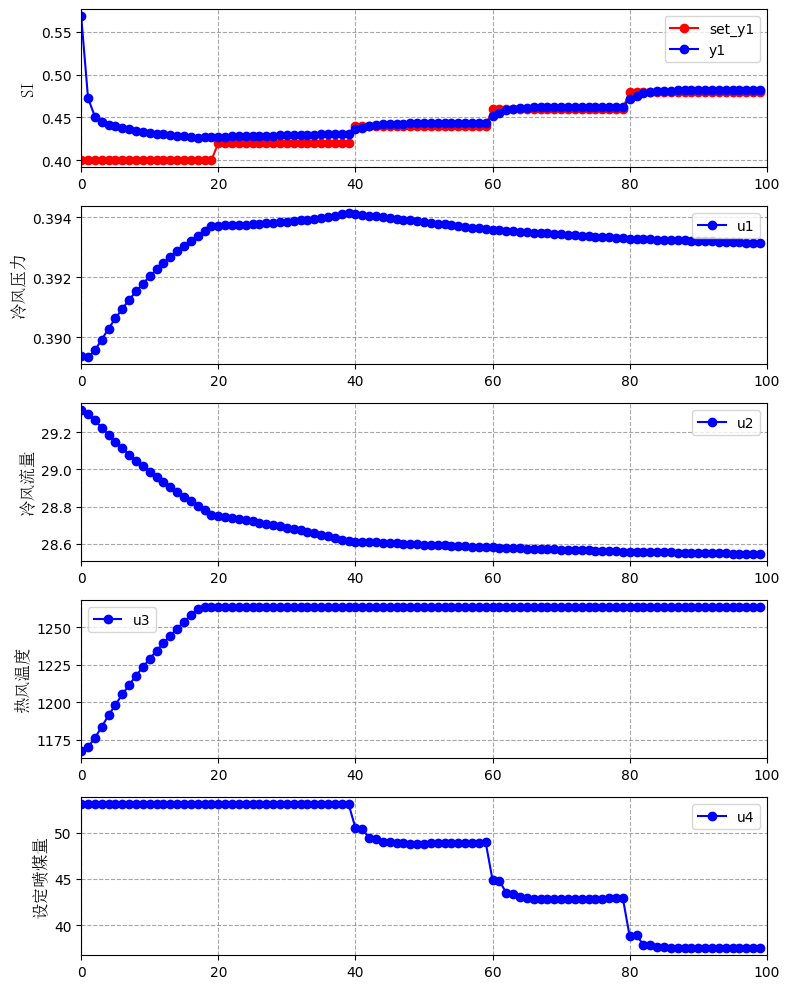

In [120]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(8, 10))
y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1).reshape(-1, 1)).flatten()
all_pred_u1_inverse_transform = scalers[input_term[0]].inverse_transform(np.array(all_pred_u1).reshape(-1, 1)).flatten()
all_pred_u2_inverse_transform = scalers[input_term[1]].inverse_transform(np.array(all_pred_u2).reshape(-1, 1)).flatten()
all_pred_u3_inverse_transform = scalers[input_term[2]].inverse_transform(np.array(all_pred_u3).reshape(-1, 1)).flatten()
all_pred_u4_inverse_transform = scalers[input_term[3]].inverse_transform(np.array(all_pred_u4).reshape(-1, 1)).flatten()
a1 = scalers[input_term[0]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a2 = scalers[input_term[1]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a3 = scalers[input_term[2]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a4 = scalers[input_term[3]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
print(f'上线分别是：{a1}、{a2}、{a3}、{a4}')
# print(all_pred_u1)
# print(all_pred_u2)
# print(all_pred_u3)
# print(all_pred_u4)
# 第一个维度的曲线
plt.subplot(5, 1, 1)
plt.plot(set_y1, 'ro-', label='set_y1')
plt.plot(y1_pred_inverse_transform, 'bo-', label='y1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')


# 第一个维度的u1曲线
plt.subplot(5, 1, 2)
plt.plot(all_pred_u1_inverse_transform, 'bo-', label='u1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(input_term[0], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的u2曲线
plt.subplot(5, 1, 3)
plt.plot(all_pred_u2_inverse_transform, 'bo-', label='u2')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(input_term[1], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第三个维度的u3曲线
plt.subplot(5, 1, 4)
plt.plot(all_pred_u3_inverse_transform, 'bo-', label='u3')  # 修改标签为 'u3'
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(input_term[2], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第四个维度的u4曲线
plt.subplot(5, 1, 5)
plt.plot(all_pred_u4_inverse_transform, 'bo-', label='u4')  # 修改标签为 'u4'
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(input_term[3], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 调整子图布局
plt.tight_layout()
plt.show()


上线分别是：[0.4344341  0.35020406]、[33.16828629 27.14167883]、[1263.5221402   841.53712915]、[53.10015501  6.3258078 ]


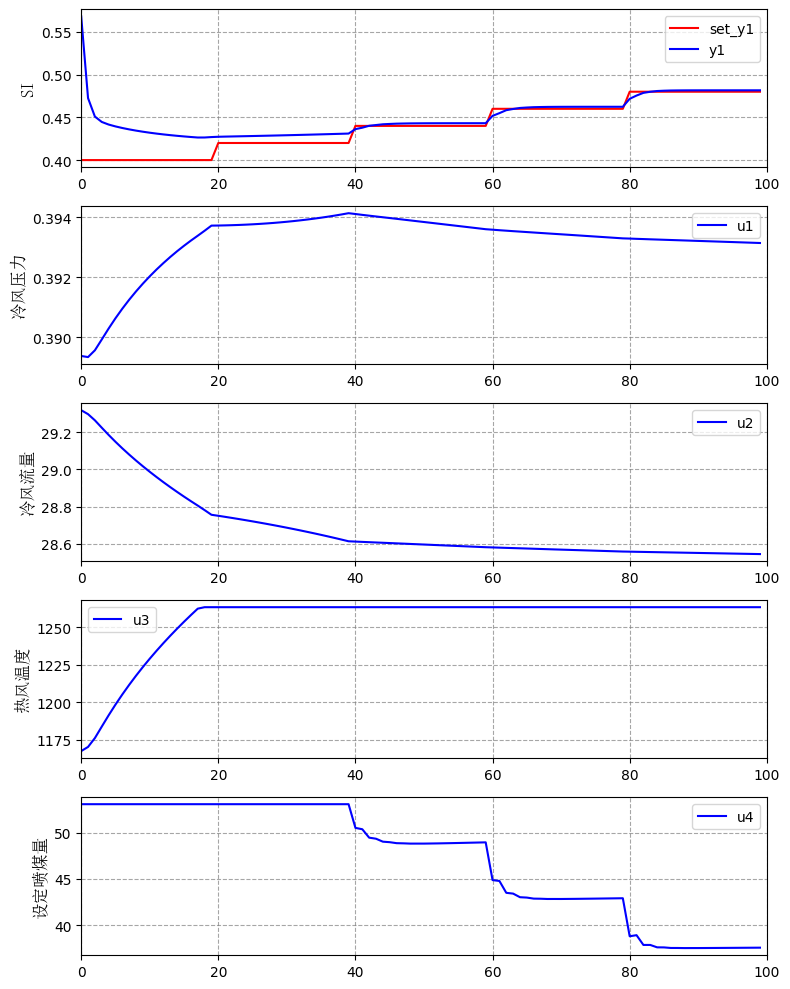

In [121]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(8, 10))
y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1).reshape(-1, 1)).flatten()
all_pred_u1_inverse_transform = scalers[input_term[0]].inverse_transform(np.array(all_pred_u1).reshape(-1, 1)).flatten()
all_pred_u2_inverse_transform = scalers[input_term[1]].inverse_transform(np.array(all_pred_u2).reshape(-1, 1)).flatten()
all_pred_u3_inverse_transform = scalers[input_term[2]].inverse_transform(np.array(all_pred_u3).reshape(-1, 1)).flatten()
all_pred_u4_inverse_transform = scalers[input_term[3]].inverse_transform(np.array(all_pred_u4).reshape(-1, 1)).flatten()
a1 = scalers[input_term[0]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a2 = scalers[input_term[1]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a3 = scalers[input_term[2]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a4 = scalers[input_term[3]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
print(f'上线分别是：{a1}、{a2}、{a3}、{a4}')
# print(all_pred_u1)
# print(all_pred_u2)
# print(all_pred_u3)
# print(all_pred_u4)
# 第一个维度的曲线
plt.subplot(5, 1, 1)
plt.plot(set_y1, 'r', label='set_y1')
plt.plot(y1_pred_inverse_transform, 'b', label='y1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')


# 第一个维度的u1曲线
plt.subplot(5, 1, 2)
plt.plot(all_pred_u1_inverse_transform, 'b', label='u1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(input_term[0], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的u2曲线
plt.subplot(5, 1, 3)
plt.plot(all_pred_u2_inverse_transform, 'b', label='u2')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(input_term[1], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第三个维度的u3曲线
plt.subplot(5, 1, 4)
plt.plot(all_pred_u3_inverse_transform, 'b', label='u3')  # 修改标签为 'u3'
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(input_term[2], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第四个维度的u4曲线
plt.subplot(5, 1, 5)
plt.plot(all_pred_u4_inverse_transform, 'b', label='u4')  # 修改标签为 'u4'
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,Times))
plt.ylabel(input_term[3], fontproperties=font)  # 使用中文标签
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 调整子图布局
plt.tight_layout()
plt.show()
